<a href="https://colab.research.google.com/github/vonvolous/python_AI_lecture/blob/main/lecture_code/DL004_PyTorch_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DNN using PyTorch**

## **1. Fashion MNIST 데이터 셋 알아보기**

### 1-1. Fashion MNIST 데이터 셋

In [1]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# pytorch에서 사용하는 tensor로 변형해줌
transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
trainset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False,
    download  = True,
    transform = transform
)

100%|██████████| 26421880/26421880 [00:01<00:00, 14971686.55it/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273020.54it/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5063678.08it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20029941.55it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [4]:
batch_size = 16

train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size
)

In [5]:
dataiter       = iter(train_loader)
images, labels = next(dataiter)

### 1-2. 멀리서 살펴보기


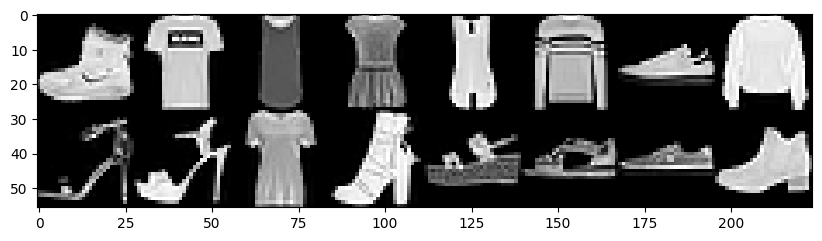

In [6]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [7]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [8]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


for label in labels:
    index = label.item()
    print(CLASSES[index])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


### 1-3. 가까이서 살펴보기


(28, 28)


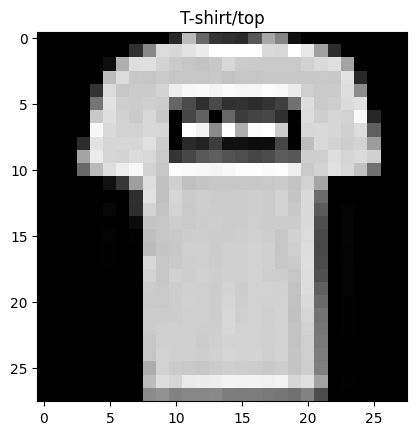

In [9]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

## **2. 인공신경망으로 패션 아이템 분류하기**

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [11]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [12]:
EPOCHS = 30
BATCH_SIZE = 64

### 2-1. 데이터셋 불러오기

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [14]:
trainset = datasets.FashionMNIST(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False,
    download  = True,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

### 2-2. 신경망으로 Fashion MNIST 학습하기

- 입력 `x` 는 `[배치크기, 색, 높이, 넓이]`로 이루어짐
- `x.size()`는 [64, 1, 28, 28]
- Fashion MNIST에서 이미지의 크기는 28 x 28 (=784), 색은 흑백으로 1 가지
- 사용할 모델은 3개의 레이어를 가진 인공신경망

- 모델 준비
  - `to()` 함수는 모델의 파라미터들을 지정한 곳으로 보내는 역할
  - 일반적으로 CPU 1개만 사용할 경우 필요는 없지만, GPU를 사용하고자 하는 경우 `to("cuda")`로 지정하여 GPU로 보내야 함
  - 지정하지 않을 경우 계속 CPU에 남아 있게 되며 빠른 훈련의 이점을 누리실 수 없음
  - 최적화 알고리즘(Optimizer)으로는 파이토치에 내장되어 있는 `optim.SGD`를 사용

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
model        = Net().to(DEVICE)
optimizer    = optim.SGD(model.parameters(), lr=0.01)

- 학습

In [17]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target), in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄

        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() # 옵티마이저 초기화
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

- 테스트

In [20]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # test 이므로 미분 필요 없음
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target, reduction = 'sum').item()

            # 가장 큰 값을 가진 클래스가 모델의 예측임
            # 에측과 정답을 비교해 일치할 경우 correct에 1 더함
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # 전체 데이터 개수만큼 나눠서 test_loss 평균 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- 실행

In [21]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    # 현재 모델에선 손실이 크긴 하지만 정확도는 좋음을 확인할 수 있음(그러나 loss와 accuracy가 항상 반비례하는 건 아님!)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8320, Accuracy: 68.78%
[2] Test Loss: 0.6643, Accuracy: 76.12%
[3] Test Loss: 0.5785, Accuracy: 79.61%
[4] Test Loss: 0.5611, Accuracy: 79.39%
[5] Test Loss: 0.5323, Accuracy: 80.90%
[6] Test Loss: 0.4986, Accuracy: 82.43%
[7] Test Loss: 0.5089, Accuracy: 81.33%
[8] Test Loss: 0.4801, Accuracy: 83.04%
[9] Test Loss: 0.4668, Accuracy: 83.54%
[10] Test Loss: 0.4534, Accuracy: 83.94%
[11] Test Loss: 0.4896, Accuracy: 82.36%
[12] Test Loss: 0.4740, Accuracy: 83.42%
[13] Test Loss: 0.4338, Accuracy: 84.60%
[14] Test Loss: 0.4423, Accuracy: 84.46%
[15] Test Loss: 0.4214, Accuracy: 85.10%
[16] Test Loss: 0.4341, Accuracy: 84.50%
[17] Test Loss: 0.4250, Accuracy: 84.70%
[18] Test Loss: 0.4276, Accuracy: 84.59%
[19] Test Loss: 0.4068, Accuracy: 85.49%
[20] Test Loss: 0.4009, Accuracy: 85.67%
[21] Test Loss: 0.3960, Accuracy: 85.93%
[22] Test Loss: 0.3939, Accuracy: 86.23%
[23] Test Loss: 0.3915, Accuracy: 86.00%
[24] Test Loss: 0.3886, Accuracy: 86.00%
[25] Test Loss: 0.3771, A

## **3. 과적합과 정규화**

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [23]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [24]:
EPOCHS = 50
BATCH_SIZE = 64

### 3-1. 데이터셋에 노이즈 추가

original.png

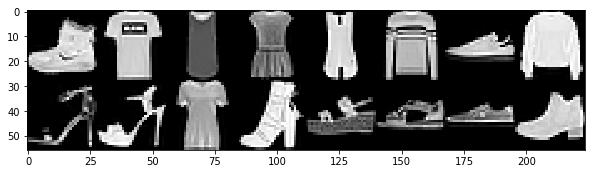

horizontalflip.png

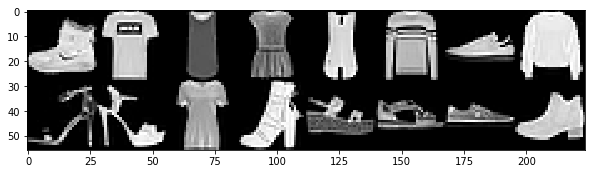

In [25]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                      # 좌우 반전
                       transforms.RandomHorizontalFlip(),
                      # 텐서로 변형
                       transforms.ToTensor(),
                      # 정규화
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

### 3-2. 신경망으로 Fashion MNIST 학습

- 모델 준비

In [26]:
class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        # 드롭아웃 확률
        self.dropout_p = dropout_p

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        # 드롭아웃 추가, training이 아니면 드롭아웃 안함!
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = F.relu(self.fc2(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = self.fc3(x)
        return x

In [27]:
model        = Net(dropout_p=0.2).to(DEVICE)
optimizer    = optim.SGD(model.parameters(), lr=0.01)

- 학습

In [28]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

- 테스트


In [29]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 맞춘 갯수 계산
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- 실행

In [30]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.6294, Accuracy: 78.05%
[2] Test Loss: 0.5364, Accuracy: 80.61%
[3] Test Loss: 0.4822, Accuracy: 82.47%
[4] Test Loss: 0.4591, Accuracy: 83.29%
[5] Test Loss: 0.4386, Accuracy: 84.18%
[6] Test Loss: 0.4213, Accuracy: 84.87%
[7] Test Loss: 0.4147, Accuracy: 84.73%
[8] Test Loss: 0.4037, Accuracy: 85.38%
[9] Test Loss: 0.3930, Accuracy: 85.79%
[10] Test Loss: 0.3872, Accuracy: 85.97%
[11] Test Loss: 0.3816, Accuracy: 85.97%
[12] Test Loss: 0.3737, Accuracy: 86.43%
[13] Test Loss: 0.3847, Accuracy: 85.77%
[14] Test Loss: 0.3662, Accuracy: 86.74%
[15] Test Loss: 0.3645, Accuracy: 86.66%
[16] Test Loss: 0.3682, Accuracy: 86.66%
[17] Test Loss: 0.3582, Accuracy: 86.91%
[18] Test Loss: 0.3588, Accuracy: 86.85%
[19] Test Loss: 0.3673, Accuracy: 86.38%
[20] Test Loss: 0.3479, Accuracy: 87.25%
[21] Test Loss: 0.3450, Accuracy: 87.54%
[22] Test Loss: 0.3414, Accuracy: 87.61%
[23] Test Loss: 0.3405, Accuracy: 87.77%
[24] Test Loss: 0.3390, Accuracy: 87.59%
[25] Test Loss: 0.3355, A